In [4]:
import pandas as pd
import os
import concurrent.futures
from tqdm import tqdm
import random
import pickle
from sklearn.model_selection import train_test_split
import torch
import pickle 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Todo timedelta interaction still have the time delta between last click in input sequence and target

In [3]:
text_num_mapping_start = 1
model_test_run = False #This reduces the data generated by selecting significantly lesser number of sessions to test the model
sequence_augmentation = True
carsi_labels_only = True
remove_consecutive_duplicates_clicks = True

PATH_TO_LOAD = '../data/04_Merged'
base_path = '../datasets/sequential/'
augmentation_folder = 'fix/' if sequence_augmentation else 'non_aug/'
if model_test_run:
    augmentation_folder = 'test/aug/' if sequence_augmentation else 'test/non_aug/'
parameter_path = f'{base_path}{augmentation_folder}parameters'
sequence_path = f'{base_path}{augmentation_folder}seq'
vehicles = ['SEB880','SEB882','SEB883','SEB885','SEB888','SEB889']

In [4]:
def load_df(vehicle):
    df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False, index_col=0)
    df = df.dropna(subset=['Label'])
    df = df.sort_values(by=['session', 'datetime'])
    if carsi_labels_only:
        df['full_label'] = df['Label']
    # else:
    #     mask = df['Label'] == 'navi/Start/Address'
    #     df.loc[mask, 'FunctionValue'] = 'a'
    #     df['full_label'] = df['Label'] + ' ' + df['FunctionValue']
    return df

def process_vehicle(vehicle):
    df_curr = load_df(vehicle)
    df_curr['vehicle'] = vehicle
    df_curr = df_curr.dropna(subset=['full_label'])
    return df_curr

result = []
for vehicle in tqdm(vehicles):
    result.append(process_vehicle(vehicle))

full_df = pd.concat(result, axis=0, ignore_index=True)

100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


In [5]:
full_df['full_label'] = full_df['full_label'].replace('car/driveMode/0', 'car/driveMode/0.0')
full_df['full_label'] = full_df['full_label'].replace('car/driveMode/2', 'car/driveMode/2.0')
full_df['full_label'] = full_df['full_label'].replace('car/driveMode/3', 'car/driveMode/3.0')

full_df['full_label'] = full_df['full_label'].replace('car/charismaLevel/Abgesenkt', 'car/charismaLevel/change')
full_df['full_label'] = full_df['full_label'].replace('car/charismaLevel/Lift', 'car/charismaLevel/change')
full_df['full_label'] = full_df['full_label'].replace('car/charismaLevel/Mittel', 'car/charismaLevel/change')
full_df['full_label'] = full_df['full_label'].replace('car/charismaLevel/Tief', 'car/charismaLevel/change')

In [6]:
sorted(full_df.full_label.unique().tolist())

['car/ESS/on',
 'car/Start/ParkAssistant',
 'car/charismaLevel/change',
 'car/driveMode/0.0',
 'car/driveMode/1.0',
 'car/driveMode/2.0',
 'car/driveMode/3.0',
 'clima/AC/ECO',
 'clima/AC/off',
 'clima/AC/on',
 'media/selectedSource/Bluetooth',
 'media/selectedSource/CarPlay',
 'media/selectedSource/Favorite',
 'media/selectedSource/Radio',
 'navi/Start/Address',
 'navi/Start/Favorite',
 'phone/Call/Favorite',
 'phone/Call/PersonX',
 'phone/Connect/NewDevice',
 'phone/Start/AndroidAuto',
 'phone/Start/CarPlay',
 'phone/goTo/Favorite']

In [7]:
len(full_df.full_label.unique().tolist())

22

In [8]:
if model_test_run:
    session = full_df.session.unique().tolist()
    random_seed = 42
    random.seed(random_seed)
    selected_elements = random.sample(session, 10)
    full_df = full_df[full_df['session'].isin(selected_elements)].sort_index()

mapping = {category: index + text_num_mapping_start for index, category in enumerate(full_df['full_label'].unique())}
full_df['full_label_num'] = full_df['full_label'].replace(mapping)

mapping['no click'] = len(full_df['full_label_num'].unique().tolist())+1

with open(os.path.join(parameter_path, 'label_mapping.pkl'), 'wb') as pickle_file:
        pickle.dump(mapping, pickle_file)

mapping_vehicle = {category: index + text_num_mapping_start for index, category in enumerate(full_df['vehicle'].unique())}
full_df['vehicle_num'] = full_df['vehicle'].replace(mapping_vehicle)

In [9]:
mapping

{'media/selectedSource/Bluetooth': 1,
 'media/selectedSource/Radio': 2,
 'media/selectedSource/Favorite': 3,
 'navi/Start/Favorite': 4,
 'navi/Start/Address': 5,
 'phone/goTo/Favorite': 6,
 'car/driveMode/0.0': 7,
 'car/driveMode/2.0': 8,
 'phone/Start/CarPlay': 9,
 'clima/AC/on': 10,
 'car/driveMode/1.0': 11,
 'car/charismaLevel/change': 12,
 'car/ESS/on': 13,
 'car/driveMode/3.0': 14,
 'phone/Start/AndroidAuto': 15,
 'clima/AC/off': 16,
 'phone/Connect/NewDevice': 17,
 'phone/Call/Favorite': 18,
 'phone/Call/PersonX': 19,
 'clima/AC/ECO': 20,
 'car/Start/ParkAssistant': 21,
 'media/selectedSource/CarPlay': 22,
 'no click': 23}

22


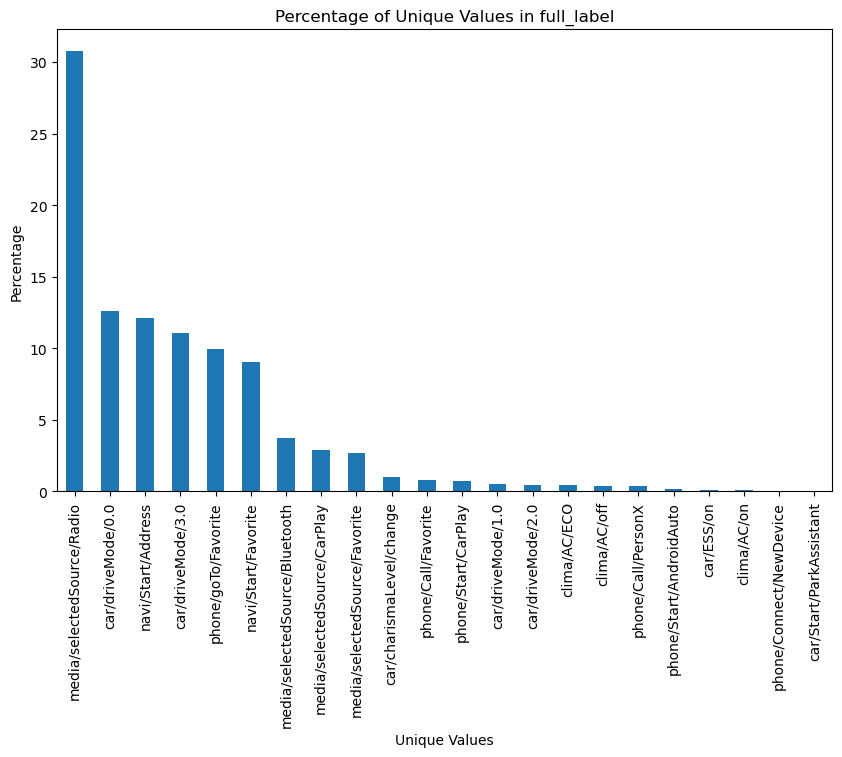

In [10]:
check = full_df.copy()
print(len(check['full_label'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = check['full_label'].value_counts(normalize=True) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [11]:
filt_df = full_df[['session','full_label_num','vehicle_num', 'datetime']].sort_values(by = ['session', 'datetime'])
filt_df = filt_df.drop_duplicates().reset_index(drop=True)

filt_df['interaction_time_delta'] = (filt_df.groupby('session')['datetime'].diff().dt.total_seconds()/60).round(1)
filt_df['interaction_time_delta'] = filt_df['interaction_time_delta'].fillna(0)
filt_df['interaction_time_delta']   = filt_df['interaction_time_delta'].astype(int)


In [12]:
filt_df

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
0,7.0,1,1,2022-09-07 21:00:51,0
1,16.0,2,1,2022-09-09 17:52:06,0
2,16.0,1,1,2022-09-09 18:02:19,10
3,16.0,2,1,2022-09-09 18:24:03,21
4,16.0,2,1,2022-09-09 18:43:10,19
...,...,...,...,...,...
7081,5389.0,2,6,2023-03-28 17:22:34,0
7082,5389.0,6,6,2023-03-28 18:38:29,75
7083,5399.0,7,6,2023-03-31 15:40:58,0
7084,5399.0,11,6,2023-03-31 16:08:18,27


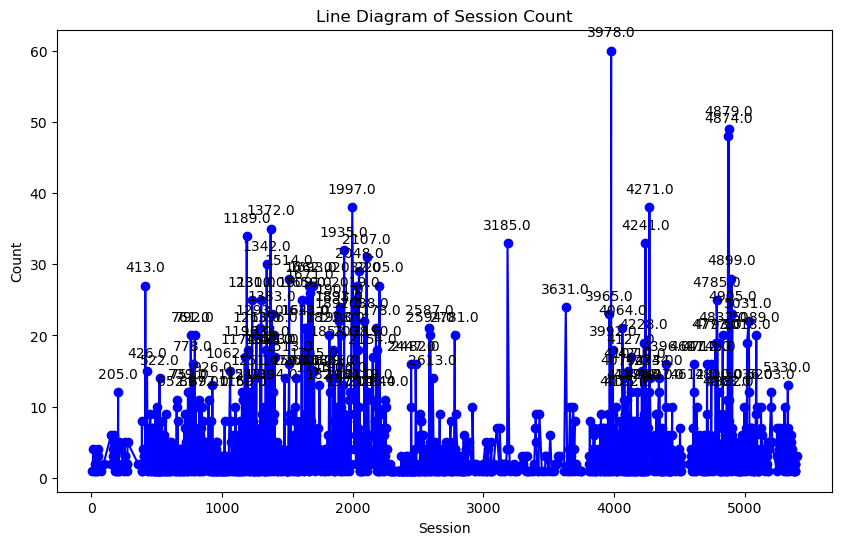

In [13]:
data = filt_df.session.value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index, data.values, marker='o', linestyle='-', color='b')

for session, count in data.items():
    if count > 10:
        plt.annotate(f'{session}', (session, count), textcoords="offset points", xytext=(0, 10), ha='center')


# Adding labels and title
plt.xlabel('Session')
plt.ylabel('Count')
plt.title('Line Diagram of Session Count')

# Display the plot
plt.show()

22
{'media/selectedSource/Bluetooth': 1, 'media/selectedSource/Radio': 2, 'media/selectedSource/Favorite': 3, 'navi/Start/Favorite': 4, 'navi/Start/Address': 5, 'phone/goTo/Favorite': 6, 'car/driveMode/0.0': 7, 'car/driveMode/2.0': 8, 'phone/Start/CarPlay': 9, 'clima/AC/on': 10, 'car/driveMode/1.0': 11, 'car/charismaLevel/change': 12, 'car/ESS/on': 13, 'car/driveMode/3.0': 14, 'phone/Start/AndroidAuto': 15, 'clima/AC/off': 16, 'phone/Connect/NewDevice': 17, 'phone/Call/Favorite': 18, 'phone/Call/PersonX': 19, 'clima/AC/ECO': 20, 'car/Start/ParkAssistant': 21, 'media/selectedSource/CarPlay': 22, 'no click': 23}


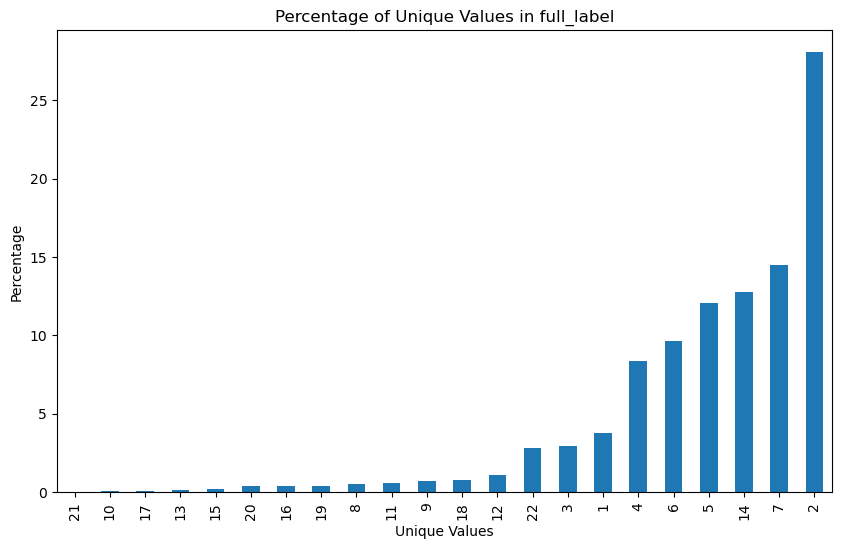

In [14]:
print(len(filt_df['full_label_num'].unique().tolist()))
print(mapping)
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = filt_df['full_label_num'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [15]:
# To do add those session with just one interactions. that one interaction can the target and input sequence can be no click along with the context
# find session with just one interactions
session_counts = filt_df['session'].value_counts()
session_with_one_interactions = session_counts[session_counts == 1].index.tolist()
one_interactions = filt_df[filt_df['session'].isin(session_with_one_interactions)]
print(len(one_interactions.session.unique().tolist()))

431


In [16]:
one_interactions

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
0,7.0,1,1,2022-09-07 21:00:51,0
5,20.0,2,1,2022-09-10 17:15:06,0
8,27.0,1,1,2022-09-11 12:26:02,0
17,45.0,4,1,2022-09-16 07:13:03,0
18,46.0,6,1,2022-09-16 11:36:04,0
...,...,...,...,...,...
7072,5373.0,2,6,2023-03-25 15:20:25,0
7073,5375.0,2,6,2023-03-26 08:29:12,0
7074,5384.0,2,6,2023-03-28 08:10:54,0
7075,5385.0,2,6,2023-03-28 09:06:58,0


In [17]:
import pandas as pd
from datetime import timedelta

# Assuming df is your DataFrame
# Create a timedelta of 30 seconds
time_delta = timedelta(seconds=30)

# Iterate over each row
new_rows = []
for index, row in one_interactions.iterrows():
    # Create a new row with the specified values
    new_row = {
        'session': row['session'],
        'full_label_num': len(filt_df['full_label_num'].unique().tolist())+1,
        'vehicle_num': row['vehicle_num'],
        'datetime': row['datetime'] - time_delta,
        'interaction_time_delta': 0
    }
    new_rows.append(new_row)

# Concatenate the original DataFrame with the new rows
one_interactions_w_empty_click = pd.concat([one_interactions, pd.DataFrame(new_rows)], ignore_index=True)

# Sort the DataFrame based on datetime column
one_interactions_w_empty_click.sort_values(by=['session', 'datetime'], inplace=True)

# Reset index
one_interactions_w_empty_click.reset_index(drop=True, inplace=True)
one_interactions_w_empty_click

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
0,7.0,23,1,2022-09-07 21:00:21,0
1,7.0,1,1,2022-09-07 21:00:51,0
2,20.0,23,1,2022-09-10 17:14:36,0
3,20.0,2,1,2022-09-10 17:15:06,0
4,27.0,23,1,2022-09-11 12:25:32,0
...,...,...,...,...,...
857,5384.0,2,6,2023-03-28 08:10:54,0
858,5385.0,23,6,2023-03-28 09:06:28,0
859,5385.0,2,6,2023-03-28 09:06:58,0
860,5386.0,23,6,2023-03-28 10:09:42,0


In [18]:
relevanat_df = filt_df[~filt_df['session'].isin(session_with_one_interactions)]
print(len(relevanat_df.session.unique().tolist()))
# this is used to generate the appropriate context file
# relevanat_df[['session', 'datetime']].to_csv(os.path.join(parameter_path, 'sequence_context.csv'))

1203


In [19]:
filt_df_new = filt_df[~filt_df['session'].isin(session_with_one_interactions)]
filt_df_new = pd.concat([filt_df_new, one_interactions_w_empty_click], ignore_index=True)

# Sort the DataFrame based on datetime column
filt_df_new.sort_values(by=['session', 'datetime'], inplace=True)

# Reset index
filt_df_new.reset_index(drop=True, inplace=True)
filt_df_new[['session', 'datetime']].to_csv(os.path.join(parameter_path, 'sequence_context.csv'))

In [20]:
filt_df_new

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
0,7.0,23,1,2022-09-07 21:00:21,0
1,7.0,1,1,2022-09-07 21:00:51,0
2,16.0,2,1,2022-09-09 17:52:06,0
3,16.0,1,1,2022-09-09 18:02:19,10
4,16.0,2,1,2022-09-09 18:24:03,21
...,...,...,...,...,...
7512,5389.0,2,6,2023-03-28 17:22:34,0
7513,5389.0,6,6,2023-03-28 18:38:29,75
7514,5399.0,7,6,2023-03-31 15:40:58,0
7515,5399.0,11,6,2023-03-31 16:08:18,27


In [21]:
filt_df_new[['session', 'datetime']]

,session,datetime
0,7.0,2022-09-07 21:00:21
1,7.0,2022-09-07 21:00:51
2,16.0,2022-09-09 17:52:06
3,16.0,2022-09-09 18:02:19
4,16.0,2022-09-09 18:24:03
...,...,...
7512,5389.0,2023-03-28 17:22:34
7513,5389.0,2023-03-28 18:38:29
7514,5399.0,2023-03-31 15:40:58
7515,5399.0,2023-03-31 16:08:18


In [22]:
filt_df_new

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
0,7.0,23,1,2022-09-07 21:00:21,0
1,7.0,1,1,2022-09-07 21:00:51,0
2,16.0,2,1,2022-09-09 17:52:06,0
3,16.0,1,1,2022-09-09 18:02:19,10
4,16.0,2,1,2022-09-09 18:24:03,21
...,...,...,...,...,...
7512,5389.0,2,6,2023-03-28 17:22:34,0
7513,5389.0,6,6,2023-03-28 18:38:29,75
7514,5399.0,7,6,2023-03-31 15:40:58,0
7515,5399.0,11,6,2023-03-31 16:08:18,27


In [23]:
## Generating augmented data
def explode_both(row):
        sequences = row['sequence']
        time_deltas = row['time_delta']
        timestamp_target_interaction = row['timestamp_target_interaction']
        sessions = [row['session']] * len(sequences)
        return pd.DataFrame({'session': sessions, 'sequence': sequences, 
                             'time_delta': time_deltas, 'timestamp_target_interaction': timestamp_target_interaction})

def sequence_generation(df, sequence_augmentation):
    sequence_dict = {
        'session': [],
        'sequence': [],
        'time_delta': [],
        'timestamp_target_interaction': []
    }
    if sequence_augmentation == True:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]

            sequence_list = []
            time_delta_list = []
            timestamp_target_interaction_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            timestamp_target_interaction =check_df['datetime'].tolist()
            # print(session)
            # print(seq_length)
            # print(sequence)
            # print(time_delta)
            while seq_length != 1:
                sequence_list.append(sequence)
                time_delta_list.append(time_delta)
                timestamp_target_interaction_list.append(timestamp_target_interaction)
                # print(sequence_list)
                # print(time_delta_list)
                time_delta = time_delta[:-1]
                sequence = sequence[:-1]
                timestamp_target_interaction = timestamp_target_interaction[:-1]
                seq_length = seq_length -1
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence_list)
            sequence_dict['time_delta'].append(time_delta_list)
            sequence_dict['timestamp_target_interaction'].append(timestamp_target_interaction_list)
        sequence_df = pd.DataFrame(sequence_dict)
        sequence_df = pd.concat(sequence_df.apply(explode_both, axis=1).tolist(), ignore_index=True)
    else:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]
            
            if len(check_df) == 1:
                 continue
            sequence_list = []
            time_delta_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            timestamp_target_interaction = check_df['datetime'].tolist()
            
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence)
            sequence_dict['time_delta'].append(time_delta)
            sequence_dict['timestamp_target_interaction'].append(timestamp_target_interaction)
        sequence_df = pd.DataFrame(sequence_dict)

    return sequence_df

# clean_df = filt_df_new.drop(columns=['datetime', 'vehicle_num'])
df_exploded = sequence_generation(filt_df_new, sequence_augmentation)
df_exploded['timestamp_target_interaction'] = df_exploded['timestamp_target_interaction'].apply(lambda x: x[-1])
df_exploded['time_delta_list'] = df_exploded['time_delta'].apply(lambda x: x[1:] if isinstance(x, list) and len(x) > 1 else x)
df_exploded['interaction_time_delta_train'] = df_exploded['time_delta_list'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
df_exploded['item_id_seq_train'] = df_exploded['sequence'].apply(lambda x: ' '.join(map(str, x[:-1])) if isinstance(x, list) and len(x) > 1 else None)
df_exploded['item_id_target'] = df_exploded['sequence'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)
df_exploded = df_exploded.dropna(subset=['item_id_target'])
df_exploded['item_id_target'] = df_exploded['item_id_target'].astype(int)
df_exploded = df_exploded.drop(columns=['sequence', 'time_delta', 'time_delta_list'])

In [24]:
filt_df_new[filt_df_new.session==16]

,session,full_label_num,vehicle_num,datetime,interaction_time_delta
2,16.0,2,1,2022-09-09 17:52:06,0
3,16.0,1,1,2022-09-09 18:02:19,10
4,16.0,2,1,2022-09-09 18:24:03,21
5,16.0,2,1,2022-09-09 18:43:10,19


In [25]:
df_exploded

,session,timestamp_target_interaction,interaction_time_delta_train,item_id_seq_train,item_id_target
0,7.0,2022-09-07 21:00:51,0,23,1
1,16.0,2022-09-09 18:43:10,10 21 19,2 1 2,2
2,16.0,2022-09-09 18:24:03,10 21,2 1,2
3,16.0,2022-09-09 18:02:19,10,2,1
4,20.0,2022-09-10 17:15:06,0,23,2
...,...,...,...,...,...
5878,5387.0,2023-03-28 12:54:10,0,5,6
5879,5388.0,2023-03-28 14:16:00,8,7,14
5880,5389.0,2023-03-28 18:38:29,75,2,6
5881,5399.0,2023-03-31 16:19:44,27 11,7 11,7


In [27]:
sorted(df_exploded.item_id_target.unique().tolist())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [34]:
if sequence_augmentation == True:
      total_sessions = df_exploded.session.unique().tolist()
      test_sessions, train_sessions = train_test_split(total_sessions, test_size=0.8, shuffle=True, random_state=42)
      train_df = df_exploded[df_exploded['session'].isin(train_sessions)].sort_index()
      test_df = df_exploded[df_exploded['session'].isin(test_sessions)].sort_index()
else:
      train_df, test_df = train_test_split(df_exploded, test_size=0.2, shuffle=True, random_state=42)
      train_df = train_df.sort_index()
      test_df = test_df.sort_index()
      train_sessions = train_df['session'].unique().tolist()
      test_sessions = test_df['session'].unique().tolist()

with open(os.path.join(parameter_path, 'train_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(train_sessions, pickle_file)

with open(os.path.join(parameter_path, 'test_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(test_sessions, pickle_file)

# train_df = train_df.sort_values(by='session')
# test_df = test_df.sort_values(by='session')

# train_df = train_df.drop(['session'], axis=1)
# test_df = test_df.drop(['session'], axis=1)

test_df['window_id'] = range(len(test_df))
test_df['window_id'] = test_df['window_id'].astype(int)

train_df['window_id'] = range(len(train_df))
train_df['window_id'] = train_df['window_id'].astype(int)

def remove_consecutive_duplicates(input_list):
    result = []
    removed_indices = []  # List to store indices of removed elements
    prev = None
    for i, num in enumerate(input_list):
        if num != prev:
            result.append(num)
        else:
            removed_indices.append(i)
        prev = num
    return result, removed_indices

def join_list(lst):
    return ' '.join(map(str, lst))

def create_zeros_list(lst):
    return [0] * len(lst)
    
def seq_duplicate_remove(df):
    df['interaction_time_delta_train_list'] = df['interaction_time_delta_train'].str.split().apply(lambda x: [int(i) for i in x])
    result = df['item_id_seq_train'].str.split().apply(lambda x: remove_consecutive_duplicates([int(i) for i in x]))
    # Extract cleaned list and removed indices into separate columns
    df['seq_list'] = result.apply(lambda x: x[0])
    df['removed_indices'] = result.apply(lambda x: x[1])
    
    df['seq_non_dup'] = df['seq_list'].apply(join_list)

    max_length = df['seq_list'].apply(lambda x: len(x)).max()
    print("Maximum length of lists in seq_list column:", max_length)

    empty_lists_exist = any(df['seq_list'].apply(lambda x: len(x) == 0))
    if empty_lists_exist:
        print("There are empty lists in the 'seq_list' column.")
    else:
        print("There are no empty lists in the 'seq_list' column.")

    df['wrong_time_delta_interaction_list'] = df['seq_list'].apply(create_zeros_list)
    df['wrong_time_delta_interaction'] = df['wrong_time_delta_interaction_list'].apply(join_list)

    df.drop(columns=['seq_list', 'item_id_seq_train'], inplace=True)
    df.rename(columns={'seq_non_dup': 'item_id_seq_train'}, inplace=True)

    desired_column_order = ['window_id', 'item_id_seq_train', 'item_id_target', 'wrong_time_delta_interaction', 'session', 'timestamp_target_interaction']
    df = df[desired_column_order]
    return df

if remove_consecutive_duplicates_clicks:
    test_df = seq_duplicate_remove(test_df)
    train_df = seq_duplicate_remove(train_df)
else:
    train_df = train_df[['window_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train', 'session', 'timestamp_target_interaction']]
    test_df = test_df[['window_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train', 'session', 'timestamp_target_interaction']]

test_df.to_csv(os.path.join(sequence_path, 'test.tsv'), sep='\t', index=False)
train_df.to_csv(os.path.join(sequence_path, 'train.tsv'), sep='\t', index=False)

Maximum length of lists in seq_list column: 38
There are no empty lists in the 'seq_list' column.
Maximum length of lists in seq_list column: 52
There are no empty lists in the 'seq_list' column.


In [6]:
file_path = os.path.join(sequence_path, 'train.tsv')
train_data = pd.read_csv(file_path, sep='\t')
file_path = os.path.join(sequence_path, 'test.tsv')
test_data = pd.read_csv(file_path, sep='\t')
data = pd.concat([train_data, test_data], axis=0)
data

,window_id,item_id_seq_train,item_id_target,wrong_time_delta_interaction,session,timestamp_target_interaction
0,0,23,1,0,7.0,2022-09-07 21:00:51
1,1,23,2,0,20.0,2022-09-10 17:15:06
2,2,3,2,0,25.0,2022-09-11 10:28:01
3,3,23,1,0,27.0,2022-09-11 12:26:02
4,4,4,5,0,33.0,2022-09-12 17:09:43
...,...,...,...,...,...,...
1254,1254,5 14 7 5,5,0 0 0 0,5346.0,2023-03-16 09:25:17
1255,1255,5 14 7,5,0 0 0,5346.0,2023-03-16 09:24:28
1256,1256,5 14,7,0 0,5346.0,2023-03-16 09:01:33
1257,1257,5,14,0,5346.0,2023-03-16 08:57:04


In [13]:

# def compute_class_weights(data):
#     labels = torch.tensor(data.item_id_target)
#     class_count = torch.bincount(labels)
#     total_samples = len(labels)
#     class_weights = 1.0 / ((class_count.float()) / total_samples)
#     # small_value = 1
#     # class_weights[torch.isinf(class_weights)] = small_value
#     # class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)
#     # sum_weights = torch.sum(class_weights)
#     # class_weights = class_weights / sum_weights
#     # class_weights[0, 0] = 1
#     return class_weights

# class_weights = compute_class_weights(df_exploded)
# # class_weights = class_weights[1:]
# with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
#         pickle.dump(class_weights, f)

# print(class_weights.size(), len(df_exploded.item_id_target.unique().tolist()))
# print(class_weights)

class_frequencies = data['item_id_target'].value_counts(normalize=True)
total_samples = len(data)
class_weights = {label: total_samples / (len(class_frequencies) * freq) for label, freq in class_frequencies.items()}
# class_weights_tensor = torch.tensor(list(class_weights.values()))
total_weights = sum(class_weights.values())
# normalized_class_weights = {label: weight / total_weights for label, weight in class_weights.items()}
class_weights[0] = 0
class_weights[23] = 0
sorted_class_weights = dict(sorted(class_weights.items()))
class_weights_tensor_list = torch.tensor(list(sorted_class_weights.values()))
print(class_weights_tensor_list)

with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
        pickle.dump(class_weights_tensor_list, f)

tensor([0.0000e+00, 7.0546e+03, 1.0052e+03, 9.3641e+03, 3.3687e+03, 1.9914e+03,
        2.8244e+03, 1.5591e+03, 7.8658e+04, 3.6585e+04, 1.5732e+06, 4.7672e+04,
        2.3480e+04, 1.7480e+05, 2.4931e+03, 1.3110e+05, 6.5549e+04, 7.8658e+05,
        2.9133e+04, 6.0506e+04, 6.2927e+04, 7.8658e+05, 1.0149e+04, 0.0000e+00])


In [15]:
class_weights

{2: 1005.2189660180076,
 7: 1559.1354626542934,
 5: 1991.351495972382,
 14: 2493.1342025644717,
 6: 2824.358495185246,
 4: 3368.667412886899,
 1: 7054.563595597228,
 3: 9364.093344155845,
 22: 10149.468914956013,
 12: 23480.114654002715,
 18: 29132.73484848485,
 9: 36585.29492600423,
 11: 47671.7479338843,
 19: 60506.44930069929,
 20: 62926.707272727275,
 16: 65548.6534090909,
 8: 78658.3840909091,
 15: 131097.3068181818,
 13: 174796.4090909091,
 21: 786583.8409090909,
 17: 786583.8409090909,
 10: 1573167.6818181819,
 0: 0,
 23: 0}

22


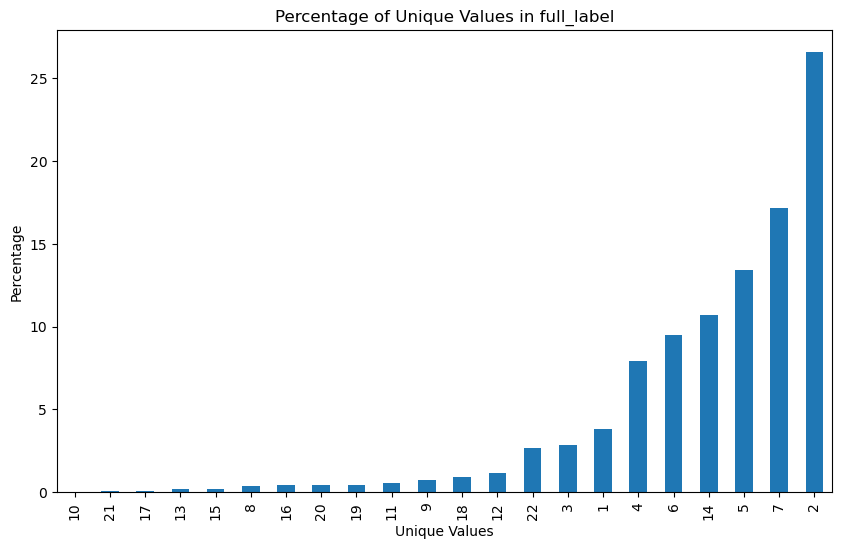

In [8]:
print(len(data['item_id_target'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = data['item_id_target'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [30]:
def session_window_mapping(df):
    session_window_dict = {}

    for index, row in df.iterrows():
        session = int(row['session'])
        window_id = int(row['window_id'])
        
        # If the session is not already in the dictionary, initialize an empty set
        if session not in session_window_dict:
            session_window_dict[session] = set()
        
        # Add the window_id to the set corresponding to the session
        session_window_dict[session].add(window_id)

    # Convert sets to lists in the resulting dictionary
    session_window_dict = {session: list(window_ids) for session, window_ids in session_window_dict.items()}
    return session_window_dict

train_session_win_id_mapping = session_window_mapping(train_df)
test_session_win_id_mapping = session_window_mapping(test_df)

with open(os.path.join(parameter_path, 'session_win_id_mapping.pkl'), 'wb') as f:
        pickle.dump(train_session_win_id_mapping, f)
        pickle.dump(test_session_win_id_mapping, f)

22


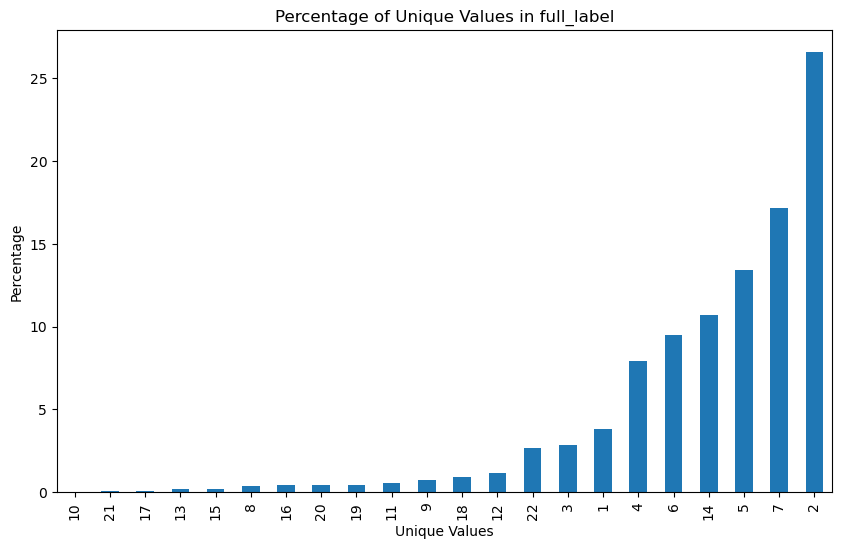

In [31]:
print(len(train_df['item_id_target'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = df_exploded['item_id_target'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


18


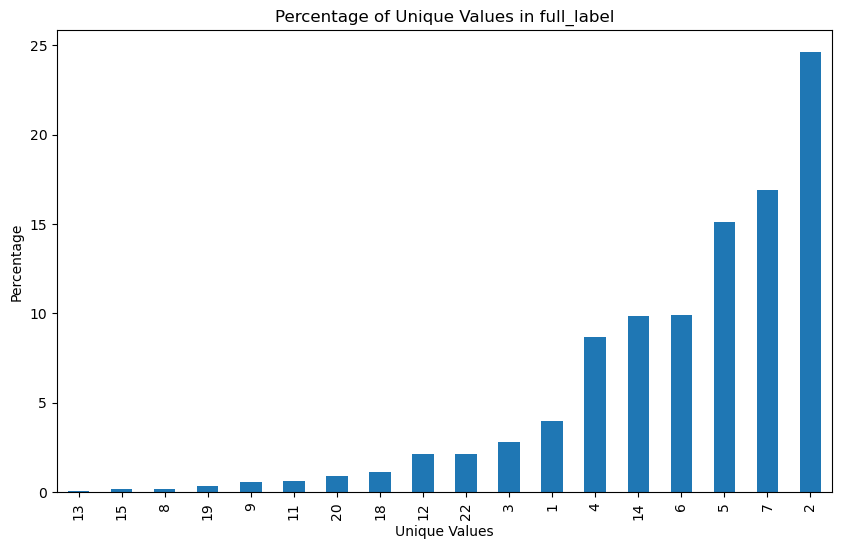

In [32]:
print(len(test_df['item_id_target'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = test_df['item_id_target'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()
